In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row
from astropy.convolution import convolve, Gaussian2DKernel

In [27]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [28]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat_1103.fits')
#('./Cutout/NSA/nsa_cutout_cat_1013.fits')

In [29]:
length = len(lsbg_cat)
bands = 4

meas_cat = Table([
    Column(name='ID', length=length, dtype=int),
    Column(name='flux', length=length, shape=(bands,)),
    Column(name='mag', length=length, shape=(bands,)),
    Column(name='SB_0', length=length, shape=(bands,)),
    Column(name='SB_eff_circ', length=length, shape=(bands,)),
    Column(name='SB_eff_ellip', length=length, shape=(bands,)),
    Column(name='xc_cen', length=length),
    Column(name='yc_cen', length=length),
    Column(name='xc_sym', length=length),
    Column(name='yc_sym', length=length),
    Column(name='ell_cen', length=length),
    Column(name='ell_sym', length=length),
    Column(name='PA_cen', length=length),
    Column(name='PA_sym', length=length),
    Column(name='rhalf_circ', length=length),
    Column(name='rhalf_ellip', length=length),
    Column(name='r20', length=length),
    Column(name='r50', length=length),
    Column(name='r80', length=length),
    Column(name='Gini', length=length),
    Column(name='M20', length=length),
    Column(name='F(G,M20)', length=length),
    Column(name='S(G,M20)', length=length),
    Column(name='C', length=length),
    Column(name='A', length=length),
    Column(name='A_outer', length=length),
    Column(name='A_shape', length=length),
    Column(name='S', length=length),
    Column(name='sersic_n', length=length),
    Column(name='sersic_rhalf', length=length),
    Column(name='sersic_ell', length=length),
    Column(name='sersic_PA', length=length),
    Column(name='sersic_xc', length=length),
    Column(name='sersic_yc', length=length),
    Column(name='sersic_amp', length=length),
    Column(name='flag', length=length, dtype=bool),
    Column(name='flag_sersic', length=length, dtype=bool),
])
for col in meas_cat.columns:
    meas_cat[col] = np.nan * meas_cat[col]

In [30]:
from kuaizi.measure import _write_to_row, measure_image_tigress

In [31]:
from IPython.display import clear_output

In [32]:
for i, lsbg in enumerate(lsbg_cat):
    clear_output(wait=True)
    
    row = meas_cat[i]
    row['ID'] = lsbg['viz-id']
    
    # Measure!
    try:
        measurement = measure_image_tigress(
            {'project': 'HSC', 
             'name': 'LSBG', 
             'data_dir': '/scratch/gpfs/jiaxuanl/Data'}, 
            lsbg, show_figure_statmorph=False, figure_dir='./Figure/statmorph/')
        row = _write_to_row(row, measurement)
#         with open(f"./Measure/NSA/nsa-{lsbg['viz-id']}-wavelet.df", "wb") as fp:
#             dill.dump([measurement, morph], fp)
#             fp.close()
    except Exception as e:
        print(i, e)
        
    if i % 5 == 0:
        print(f'Progress: {i}')

    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    6 stars from Gaia are masked!
    Detected 246 objects
    6 stars from Gaia are masked!
    Detected 203 objects
    Detected 83 objects
Progress: 500


In [33]:
meas_cat.write('./Catalog/nsa_sample_images_measurement_1119_success.fits', overwrite=True)

### Analysis

In [233]:
import kuaizi
import pickle
kuaizi.set_matplotlib(style='nature', usetex=False)

In [272]:
meas_cat = Table.read('./Catalog/nsa_vanilla_sample_measurement_1103_success.fits')
meas_cat_img = Table.read('./Catalog/nsa_sample_images_measurement_1119_success.fits')

In [273]:
meas_cat['C'] = meas_cat_img['C']
meas_cat['A'] = meas_cat_img['A']
meas_cat['A_outer'] = meas_cat_img['A_outer']
meas_cat['S'] = meas_cat_img['S']
meas_cat['Gini'] = meas_cat_img['Gini']
meas_cat['M20'] = meas_cat_img['M20']
meas_cat['F(G,M20)'] = meas_cat_img['F(G,M20)']
meas_cat['S(G,M20)'] = meas_cat_img['S(G,M20)']

In [274]:
# Add host information
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h

In [275]:
with open('./Catalog/hosts_nsa_z001_002_20hosts.pkl', 'rb') as f:
    host_cat = pickle.load(f)
host_cat['log_m_star'] = np.log10(host_cat['ELPETRO_MASS']) + np.log10(h**-2)

host_z = np.zeros(len(meas_cat))
host_mass = np.zeros(len(meas_cat))

for i, lsbg in enumerate(meas_cat):
    ind = int(lsbg['ID'])
    _match = [(host['Z'], host['log_m_star']) for host in host_cat if ind in host['1vir_lsbg_idx']]
#     if len(_match) > 1:
#         print(f'More than one is matched for {i}:', _match)
    host_z[i] = _match[0][0]
    host_mass[i] = _match[0][1]
meas_cat.add_column(Column(data=host_z, name='host_z'))
meas_cat.add_column(Column(data=host_mass, name='host_log_m_star'))

ang_diam_dist = cosmos.angular_diameter_distance(meas_cat['host_z']).value # not consider peculiar motion
rhalf_phys = meas_cat['rhalf_circ'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
meas_cat['rhalf_circ_phys'] = rhalf_phys

rhalf_phys = meas_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
meas_cat['rhalf_ellip_phys'] = rhalf_phys

rhalf_phys = meas_cat['r20'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
meas_cat['r20_phys'] = rhalf_phys

In [252]:
jg_votes = Table.read('./Catalog/20hosts/LSBG_Zoo_jgreene_2021_11_17_20_48_40.log', format='ascii')
jg_votes.rename_columns(jg_votes.colnames, ['name', 'gal', 'candy', 'junk'])
jg_votes['viz-id'] = [int(item.lstrip('nsa_')) for item in jg_votes['name']]
jg_votes.remove_column('name')
for key in ['gal', 'candy', 'junk']:
    jg_votes[key] = jg_votes[key].data.astype(bool)
    
jg_votes.sort('viz-id')

In [253]:
jl_votes = Table.read('./Catalog/20hosts/LSBG_Zoo_jiaxuanl_2021_11_17_00_27_18.log', format='ascii')
jl_votes.rename_columns(jl_votes.colnames, ['name', 'gal', 'candy', 'junk'])
jl_votes['viz-id'] = [int(item.lstrip('nsa_')) for item in jl_votes['name']]
jl_votes.remove_column('name')
for key in ['gal', 'candy', 'junk']:
    jl_votes[key] = jl_votes[key].data.astype(bool)
    
jl_votes.sort('viz-id')

In [254]:
if np.sum(meas_cat['ID'] != jl_votes['viz-id']) == 0:
    for key in ['gal', 'candy', 'junk']:
        meas_cat[key] = jg_votes[key]

In [255]:
junk = meas_cat['junk']
candy = meas_cat['candy']
gal = meas_cat['gal']

In [256]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [257]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 208
Gal: 138
Junk: 155


(-0.5, 2.2)

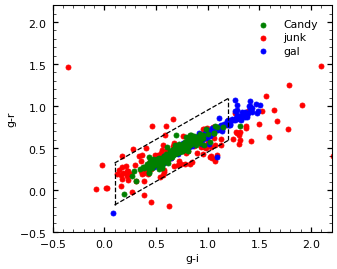

In [210]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

plt.xlim(-0.5, 2.2)
plt.ylim(-0.5, 2.2)

Text(0, 0.5, 'SB_0_i')

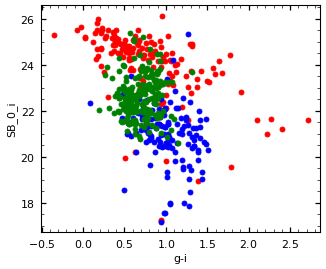

In [180]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_0'][:, 2][gal], color='b')

plt.xlabel('g-i')
plt.ylabel('SB_0_i')

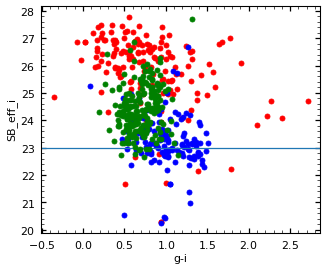

In [183]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_eff_ellip'][:, 1][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_eff_ellip'][:, 1][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_eff_ellip'][:, 1][gal], color='b')

plt.xlabel('g-i')
plt.ylabel('SB_eff_i')

plt.axhline(23.)

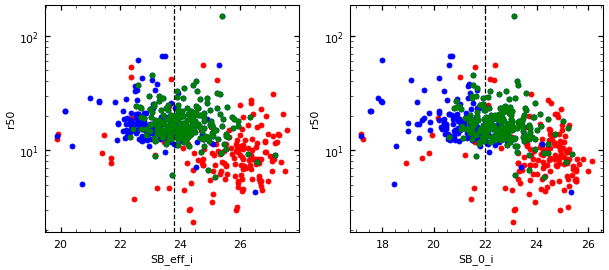

In [241]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
plt.sca(ax1)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(23.8, color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

plt.sca(ax2)
plt.scatter(meas_cat['SB_0'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_0'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_0'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(22., color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_0_i')
plt.ylabel('r50')

plt.subplots_adjust(wspace=0.2)

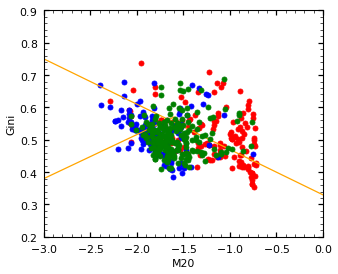

In [185]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][gal], meas_cat['Gini'][gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'A')

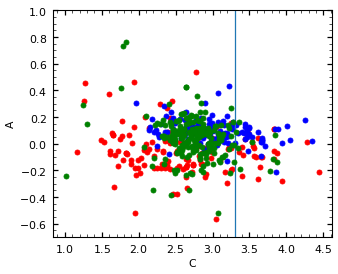

In [197]:
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A'][gal], color='b')

plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.xlabel('C')
plt.ylabel('A')

In [191]:
A_max = np.max([meas_cat['A_outer'], meas_cat['A']], axis=0)

Text(0, 0.5, 'A_max')

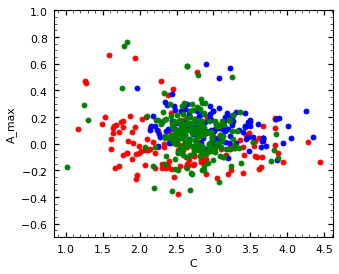

In [192]:
plt.scatter(meas_cat['C'][candy], A_max[candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], A_max[junk], color='r')
plt.scatter(meas_cat['C'][gal], A_max[gal], color='b')

plt.ylim(-.7, 1)
plt.xlabel('C')
plt.ylabel('A_max')

Text(0, 0.5, 'S')

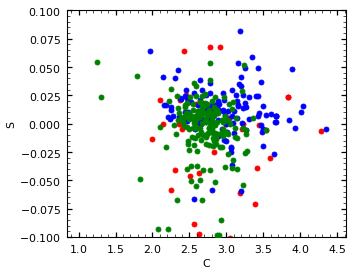

In [193]:
plt.scatter(meas_cat['C'][candy], meas_cat['S'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['S'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['S'][gal], color='b')

plt.ylim(-0.1, 0.1)
plt.xlabel('C')
plt.ylabel('S')

Text(0, 0.5, 'r50')

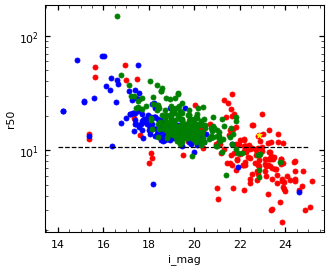

In [198]:
plt.scatter(i_mag[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter(i_mag[223], meas_cat['rhalf_ellip'][223], color='yellow', marker='*', s=50, label='gal', zorder=10)


#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

(0.0, 30.0)

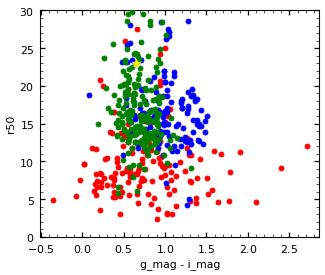

In [199]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter((g_mag - i_mag)[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=100, label='gal', zorder=10)

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)

In [242]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 208
Gal: 138
Junk: 155


In [258]:
# Cuts based on JL votes
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

#mask &= (meas_cat['SB_0'][:, 2] > 21)
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.8)

mask &= (meas_cat['M20'] < -1.0)
mask &= (meas_cat['Gini'] < 0.7)
mask &= (meas_cat['C'] < 3.5)
mask &= (meas_cat['A_outer'] < 0.1)

mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168)
print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 89
Gal: 7
Junk: 9


In [277]:
udg_flag = (meas_cat['rhalf_ellip_phys'] > 1.5) & (meas_cat['SB_0'][:, 0] > 24)

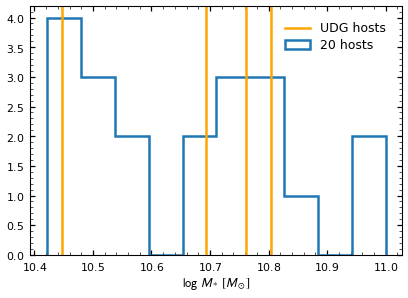

In [300]:
fig, ax = plt.subplots(figsize=(8, 5.5))
plt.hist(host_cat['log_m_star'], histtype='step', lw=3, label='20 hosts')

plt.xlabel(r'$\log\ M_*\ [M_\odot]$', fontsize=15)

for i, mass in enumerate(meas_cat[(udg_flag & mask)]['host_log_m_star']):
    label = 'UDG hosts' if i == 0 else None
    plt.axvline(mass, color='orange', lw=3, label=label)
    
plt.legend(fontsize=15)

In [280]:
meas_cat[(udg_flag & mask)]['ID']

6239.0
12516.0
29808.0
44517.0


In [ ]:
for i, lsbg in enumerate(meas_cat):
    ind = int(lsbg['ID'])
    _match = [(host['RA'], host['DEC'], 
               host['Z'], host['log_m_star']) for host in host_cat if ind in host['1vir_lsbg_idx']]

In [306]:
[(host['RA'], host['DEC'], 
               host['Z'], host['log_m_star']) for host in host_cat if 6239 in host['1vir_lsbg_idx']]

[(137.17433392133594, 0.48469687106366516, 0.018838147, 10.447762)]

In [308]:
[(host['RA'], host['DEC'], 
               host['Z'], host['log_m_star']) for host in host_cat if 12516 in host['1vir_lsbg_idx']]

[(179.59910565413685, -2.2773555235279557, 0.019673161, 10.803404)]

In [310]:
[(host['RA'], host['DEC'], 
               host['Z'], host['log_m_star']) for host in host_cat if 29808 in host['1vir_lsbg_idx']]

[(16.78818385473689, -0.6217567854398885, 0.017702786, 10.693181)]

In [311]:
[(host['RA'], host['DEC'], 
               host['Z'], host['log_m_star']) for host in host_cat if 44517 in host['1vir_lsbg_idx']]

[(18.20253435271607, -0.2901912580265797, 0.017543709, 10.760939)]

In [225]:
# Cuts based on JG votes
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)
mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168)

#mask &= (meas_cat['SB_0'][:, 2] > 21)
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23)

mask &= (meas_cat['M20'] < -1.0)
mask &= (meas_cat['Gini'] < 0.7)
mask &= (meas_cat['C'] < 3.3)

#mask &= (meas_cat['A_outer'] < 0.1)

print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 172
Gal: 33
Junk: 10


In [227]:
mask &= (meas_cat['A_outer'] < 0.1)

In [231]:
meas_cat[mask].write('./Catalog/20hosts/after_size_color_sb_cas_cut_1119_jg.fits', overwrite=True)

In [219]:
mask &= (meas_cat['A_outer'] < 0.1)

print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 111
Gal: 15
Junk: 8


In [171]:
meas_cat[mask].write('./Catalog/20hosts/after_size_color_sb_cas_cut_1119.fits')

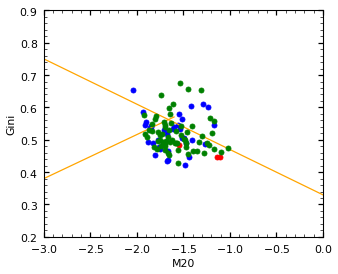

In [168]:
plt.scatter(meas_cat['M20'][mask & candy], meas_cat['Gini'][mask & candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][mask & junk], meas_cat['Gini'][mask & junk], color='r')
plt.scatter(meas_cat['M20'][mask & gal], meas_cat['Gini'][mask & gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

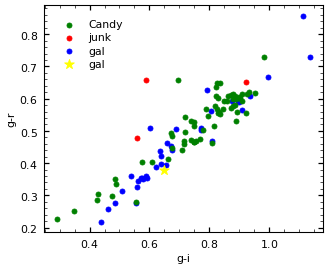

In [169]:
plt.scatter((g_mag - i_mag)[candy & mask], (g_mag - r_mag)[candy & mask], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk & mask], (g_mag - r_mag)[junk & mask], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal & mask], (g_mag - r_mag)[gal & mask], color='b', label='gal')

plt.scatter((g_mag - i_mag)[327], (g_mag - r_mag)[327], color='yellow', marker='*', s=150, label='gal', zorder=10)

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

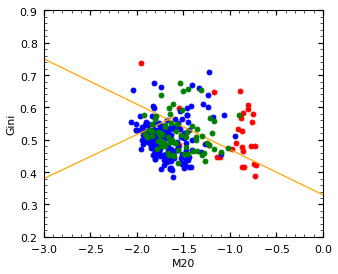

In [63]:
plt.scatter(meas_cat['M20'][candy & mask], meas_cat['Gini'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk & mask], meas_cat['Gini'][junk & mask], color='r')
plt.scatter(meas_cat['M20'][gal & mask], meas_cat['Gini'][gal & mask], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'r50')

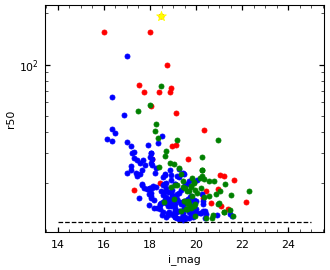

In [64]:
plt.scatter(i_mag[candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['rhalf_ellip'][gal & mask], color='b')
plt.scatter(i_mag[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=150, label='gal', zorder=10)


#plt.ylim(0, 1)
plt.hlines(2 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

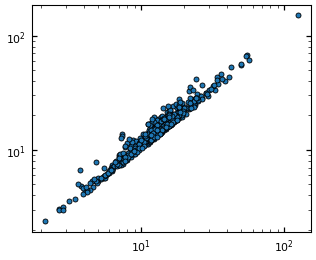

In [30]:
plt.scatter(meas_cat['r50'], meas_cat['sersic_rhalf'])
plt.xscale('log')
plt.yscale('log')

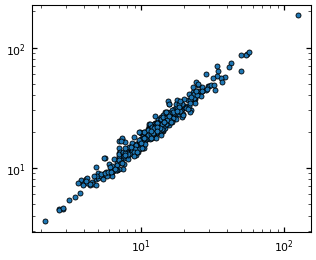

In [31]:
plt.scatter(meas_cat['r50'], meas_cat['r80'])
plt.xscale('log')
plt.yscale('log')

In [32]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 178
Gal: 167
Junk: 156


Text(0, 0.5, 'r50')

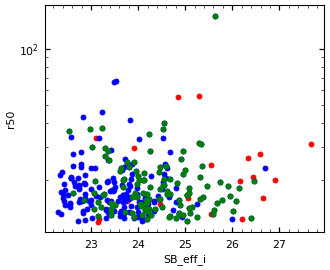

In [106]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk & mask], meas_cat['rhalf_ellip'][~junk & mask], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

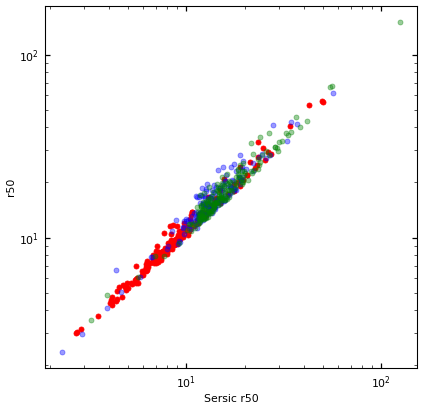

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['rhalf_circ'][candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['rhalf_circ'][junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['rhalf_circ'][gal], meas_cat['rhalf_ellip'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('Sersic r50')
plt.ylabel('r50')
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50 / r20')

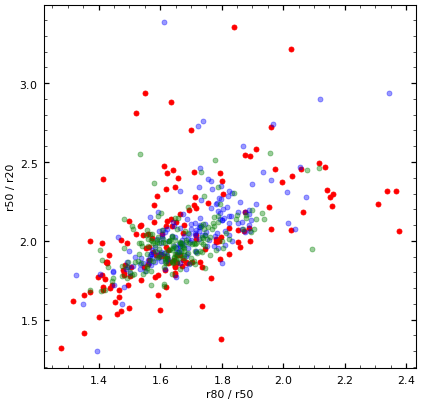

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['r80'][candy] / meas_cat['r50'][candy], 
            meas_cat['r50'][candy] / meas_cat['r20'][candy], color='g', zorder=10, alpha=.4)

plt.scatter(meas_cat['r80'][junk] / meas_cat['r50'][junk], 
            meas_cat['r50'][junk] / meas_cat['r20'][junk], color='r')

plt.scatter(meas_cat['r80'][gal] / meas_cat['r50'][gal], 
            meas_cat['r50'][gal] / meas_cat['r20'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('r80 / r50')
plt.ylabel('r50 / r20')

In [79]:
lsbg_cat[mask].write('./Catalog/nsa_20hosts_sample_211103_visual_inspect.fits', overwrite=True)

In [110]:
1.5 / (50 * 1000) * 206265

6.18795